In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/home/ubuntu/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. Загрузка данных

Загрузим данные о поездках желтого такси с января 2015 по май 2016 из ячейки 1282 (находится на Манхэттене)

In [2]:
my_cell = 1282

In [3]:
def with_0(x):
    s = str(x)
    if len(s) == 1:
        s = '0' + s
    return s

In [4]:
def read_data(year, month):
    str_month = with_0(month)
    data = pd.read_csv('Data/Prepared/yellow_tripdata_' + str(year) + '-' + str_month + '_agregated.csv')
    my_data = data[data.cell == my_cell][['time', 'num_trips']]
    print(my_data.shape)
    return my_data

In [5]:
%%time
trips_by_months = []
for month in range(1, 13):
    trips_by_months.append(read_data(2015, month))
for month in range(1, 6):
    trips_by_months.append(read_data(2016, month))

(744, 2)
(672, 2)
(744, 2)
(720, 2)
(744, 2)
(720, 2)
(744, 2)
(744, 2)
(720, 2)
(744, 2)
(720, 2)
(744, 2)
(744, 2)
(696, 2)
(744, 2)
(720, 2)
(744, 2)
CPU times: user 8.71 s, sys: 440 ms, total: 9.15 s
Wall time: 13.5 s


Теперь сольем данные за все месяцы в один массив:

In [6]:
n_trips = []
for df in trips_by_months:
    df.sort_values(by='time', inplace=True)
    n_trips += list(df['num_trips'].values)
n_trips = np.array(n_trips)
print(n_trips.shape)

(12408,)


## 2. Регрессия

Создадим следующие массивы:
$$sw_i = \sin([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_week}); sy_i = \sin([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_year})$$ 
$$cw_i = \cos([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_week}), cy_i = \cos([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_year}), i = 1, \dots, K$$
Сначала возьмем К равным 4

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
hours_in_week = 168
hours_in_year = 8766

In [9]:
def regression_residual(time_series, K, draw_plot=False):
    rng = np.arange(len(n_trips))
    X = []
    for i in range(K):
        X.append(np.sin(rng * 2 * np.pi  * (i + 1) / hours_in_week))
        X.append(np.cos(rng * 2 * np.pi  * (i + 1) / hours_in_week))
        X.append(np.sin(rng * 2 * np.pi  * (i + 1) / hours_in_year))
        X.append(np.cos(rng * 2 * np.pi  * (i + 1) / hours_in_year))
    X = np.array(X).T
    LR = LinearRegression()
    LR.fit(X, n_trips)
    residual = time_series - LR.predict(X)
    if draw_plot:
        plt.figure(figsize=(15, 7))
        beg = 5555
        plt.plot(LR.predict(X)[beg:beg + 720], label='Prediction', color='r')
        plt.plot(time_series[beg:beg + 720], label='Real data', color='b')
        plt.legend()
        plt.show()
    return (X, residual)

In [10]:
X, n_trips_residual = regression_residual(n_trips, 4)

Нарисуем график остатков регрессии за февраль и за весь период

In [11]:
def plot_residual(x):
    plt.figure(figsize=(20, 5))
    beg = 3333
    plt.plot(x[beg:beg + 720])
    plt.hlines(0, 0, 720, color='r')
    plt.title('Month')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(x, alpha=0.7)
    plt.hlines(0, 0, len(x), color='r')
    plt.title('Whole period', fontsize=16)
    plt.show()

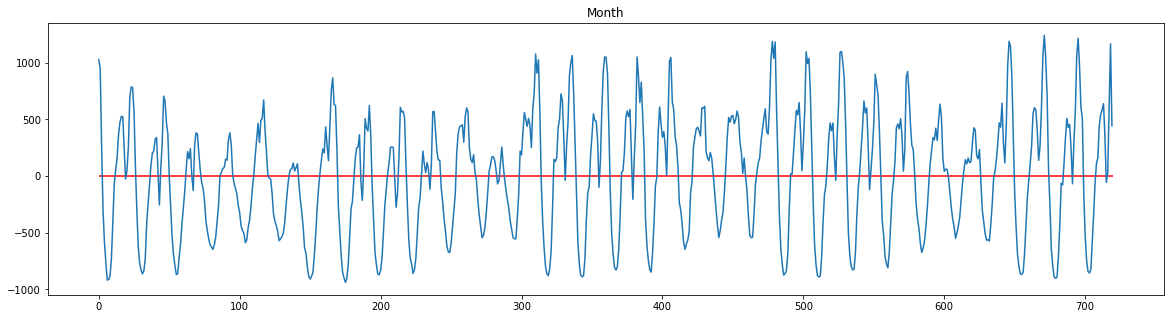

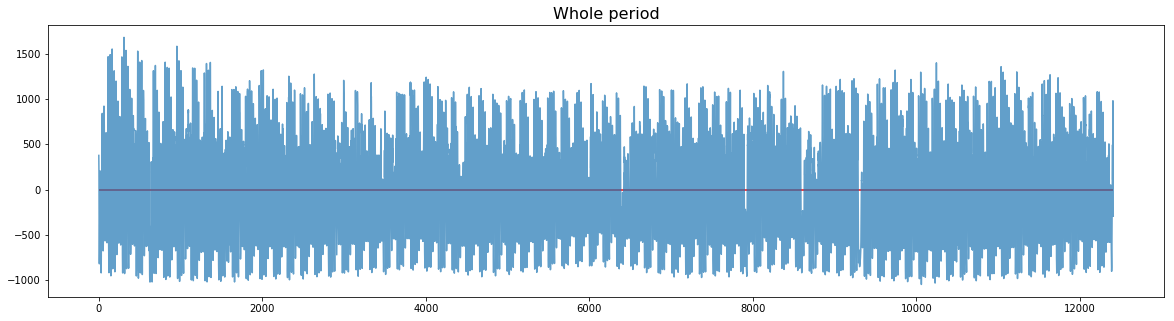

In [12]:
plot_residual(n_trips_residual)

При К=4 недельная сезонность осталась.

## 3. Модель ARIMA

Продифференцируем временной ряд сначала с шагом сутки, потом с шагом час. Построим графики продифференцированного ряда за весь период и за месяц

In [13]:
def diff_series(x, k, draw_plot=True):
    res = x[k:] - x[:-k]
    if draw_plot:
        plot_residual(res)
    return res

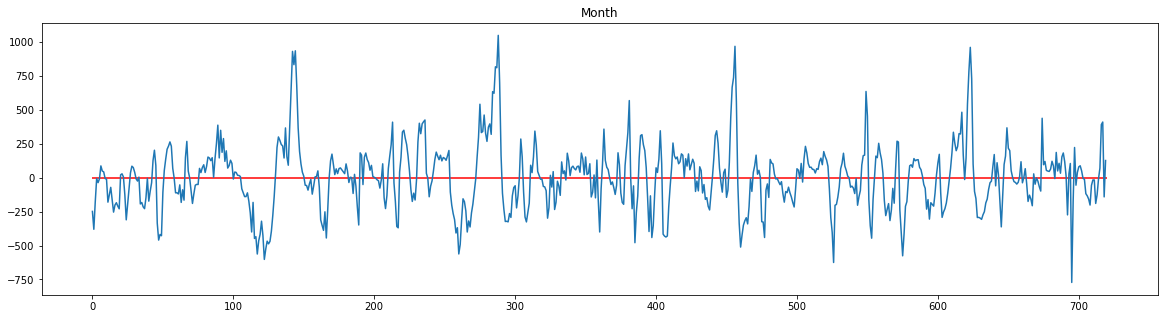

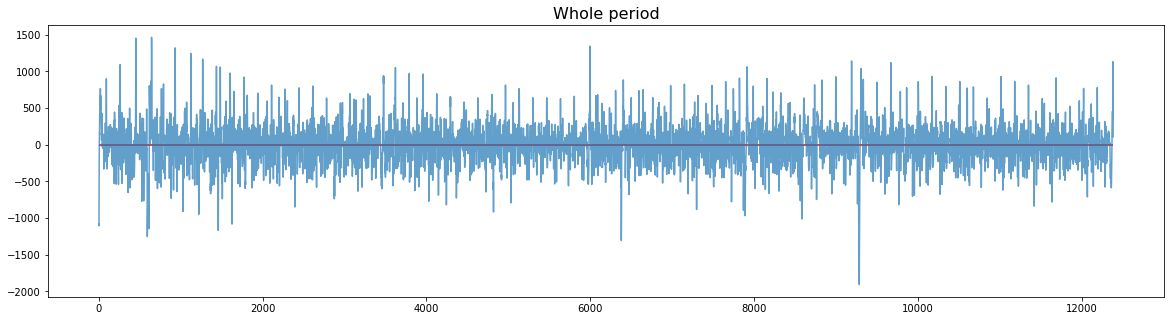

In [14]:
D1 = diff_series(n_trips_residual, 24)

Недельная сезонность осталась. Попробуем продифференцировать еще раз.

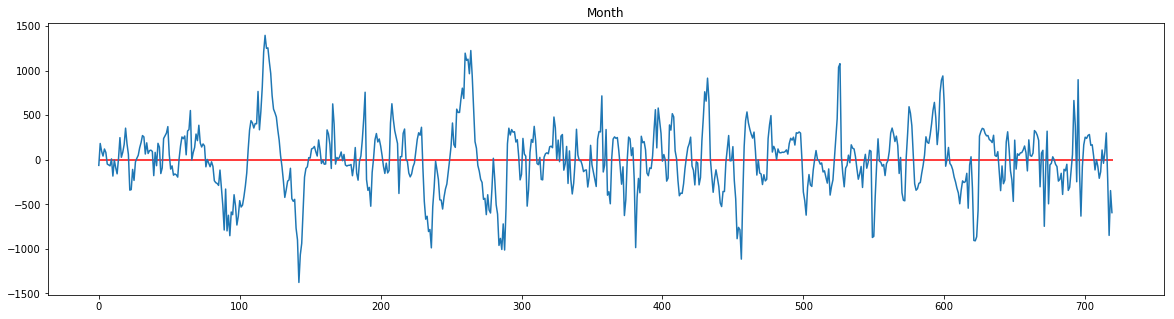

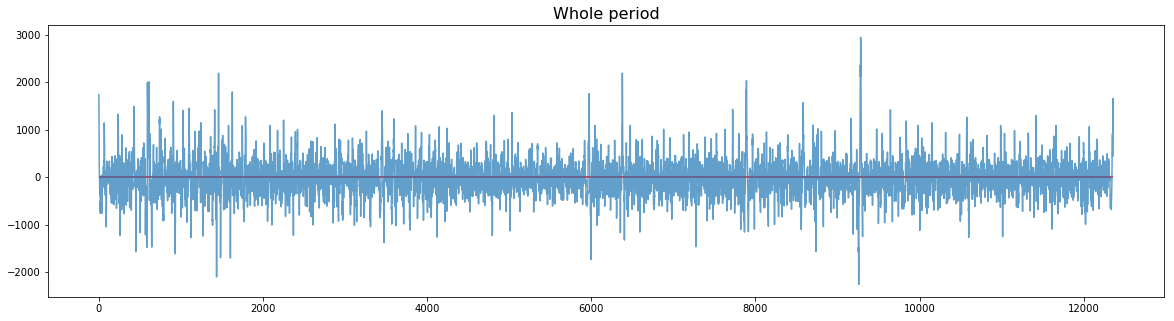

In [15]:
D2 = diff_series(D1, 24)

Теперь продифференцируем ряд с шагом 1:

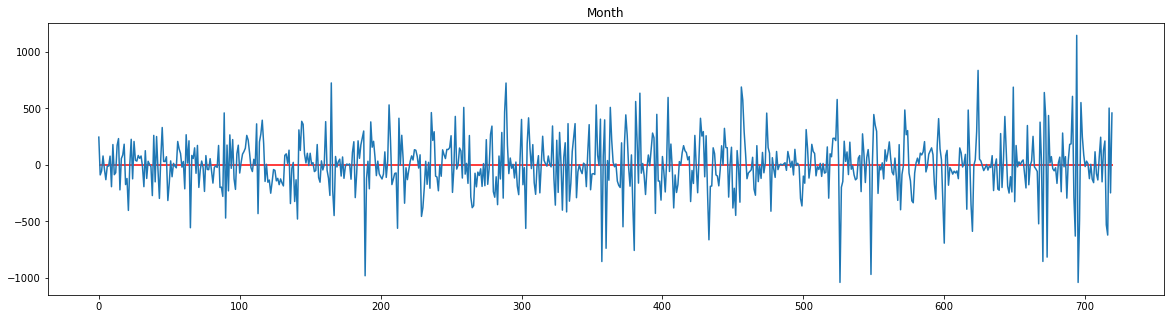

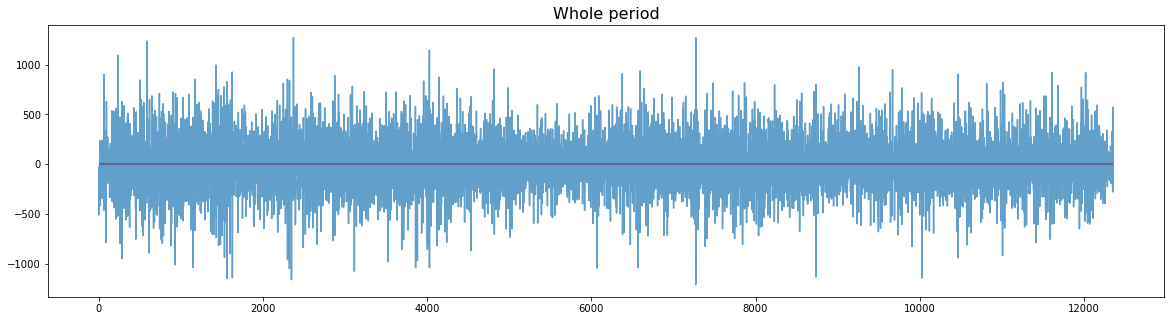

In [16]:
D3 = diff_series(D2, 1)

Ряд уже немного похож на стационарный. Посмотрим на его STL - декомпозицию и STL - декомпозицию исходного ряда:

In [17]:
import statsmodels.tsa.seasonal as sts

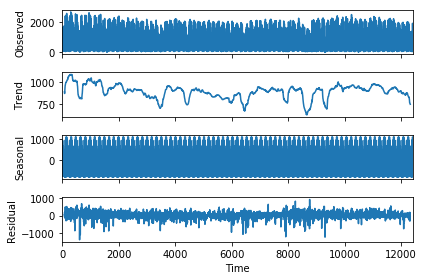

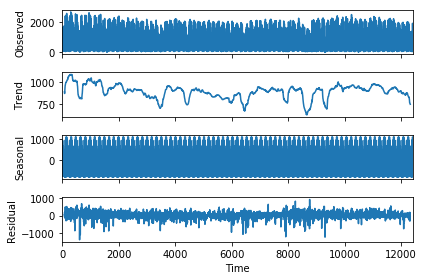

In [18]:
sts.seasonal_decompose(n_trips, freq=hours_in_week).plot()

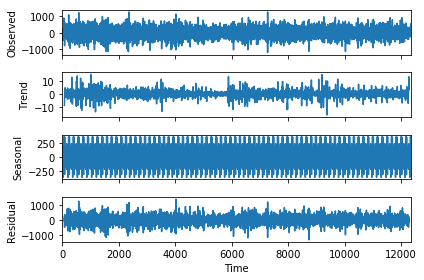

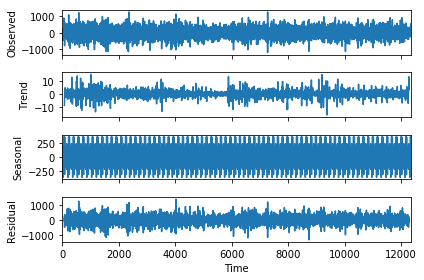

In [19]:
STL_decomposition = sts.seasonal_decompose(D3, freq=hours_in_week)
STL_decomposition.plot()

Недельная сеознность имеет размах в 4 раза меньше, чем в исходном ряде. Уже неплохо.

Построим графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) продифференцированного ряда (с лагом до года, до недели и до суток, чтобы определить, какие максимальные значения гиперпараметров модели p, q, P, Q надо брать)

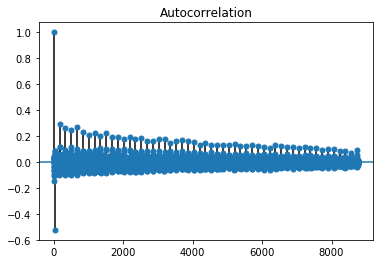

In [20]:
sm.graphics.tsa.plot_acf(D3, lags=hours_in_year, alpha=0.05)
plt.show()

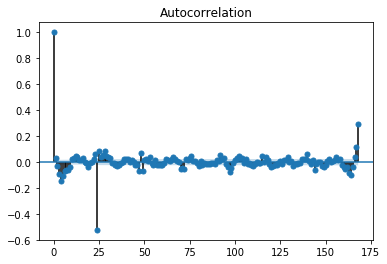

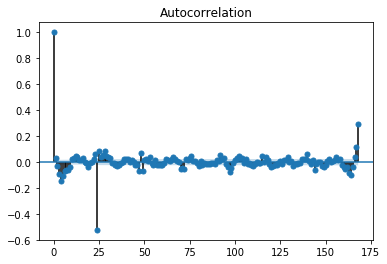

In [21]:
sm.graphics.tsa.plot_acf(D3, lags=hours_in_week, alpha=0.05)

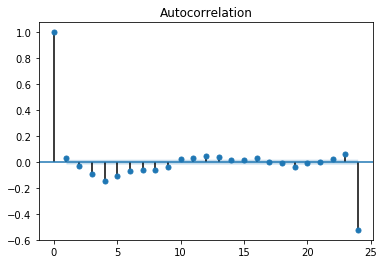

In [22]:
sm.graphics.tsa.plot_acf(D3, lags=24, alpha=0.05)
plt.show()

Частичная автокорреляция считается с квадратичной сложностью и для лага в 1 год будет строиться очень долго, поэтому нарисуем ее с лагом, равным 1 неделе.

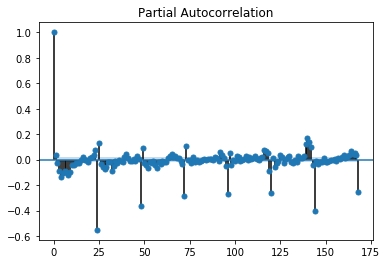

CPU times: user 3.5 s, sys: 56 ms, total: 3.55 s
Wall time: 488 ms


In [23]:
%%time
sm.graphics.tsa.plot_pacf(D3, lags=168)
plt.show()

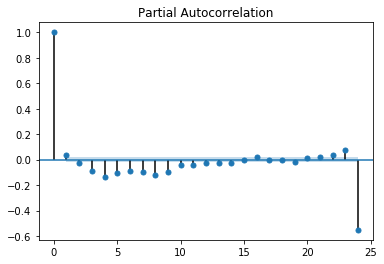

In [24]:
sm.tsa.graphics.plot_pacf(D3, lags=24)
plt.show()

Попробуем модель ARIMA на исходных данных с параметрами d=1, D=2, и параметрами p <= 4, P <= 6, q <= 4, Q <= 7

In [25]:
import statsmodels

In [30]:
%%time
for p in range(1, 5):
    for P in range(1, 7):
        for q in range(5):
            for Q in range(8):
                sarimax = sm.tsa.statespace.SARIMAX(n_trips_residual, order=(p, 1, q), seasonal_order=(P, 2, Q, 24), simple_differencing=True)
                res = sarimax.fit(disp=False)
                print(res.aic)
                break
            break
        break
    break

164598.601839
CPU times: user 9.56 s, sys: 316 ms, total: 9.88 s
Wall time: 6.64 s
